<a href="https://colab.research.google.com/github/AIGeekProgrammer/MiscellaneousAI/blob/main/CNN/CIFAR10_with_CNN_in_Pytorch_on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook:<br>
CIFAR10 with CNN using PyTorch on GPU<br>
Data divided into train, validation and test datasets<br>
Calculating accuracy for train and validation datasets to check overfitting<br>
Calculating accuracy for test dataset for final evaluation<br>
Author: Szymon Manduk<br>
Created: 19 Mar 2022<br>
Goals for blog post<br>
- How to load and divide dataset into 3 subsets?
- How to normalize and denormalize?
- How to move computations into GPU?
- How to calculate accuracy for all subsets?

In [ ]:
# main libraries
import torch
import torchvision

# All datasets in torchvision.dataset are subclasses
# of torch.utils.data.Dataset, thus we may use MNIST directly in DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# an optimizer and a loss function
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# required for creating a model
from torch.nn import Conv2d, BatchNorm2d, MaxPool2d, Linear, Dropout
import torch.nn.functional as F

# tools and helpers
import numpy as np  
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
# Transformations, including normalization based on mean and std
mean = torch.tensor([0.4915, 0.4823, 0.4468])
std = torch.tensor([0.2470, 0.2435, 0.2616])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)    
])

In [ ]:
# Download CIFAR10 dataset 
dataset = CIFAR10('./', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10('./', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dataset_length = len(dataset)
print(f'Train and validation dataset size: {dataset_length}')
print(f'Test dataset size: {len(test_dataset)}')

Train and validation dataset size: 50000
Test dataset size: 10000


In [ ]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# but they have been normalized and converted to tensors
dataset[0][0][0]

tensor([[-1.0531, -1.3072, -1.1960,  ...,  0.5187,  0.4234,  0.3599],
        [-1.7358, -1.9899, -1.7041,  ..., -0.0370, -0.1005, -0.0529],
        [-1.5930, -1.7358, -1.2119,  ..., -0.1164, -0.0847, -0.2593],
        ...,
        [ 1.3125,  1.2014,  1.1537,  ...,  0.5504, -1.1008, -1.1484],
        [ 0.8679,  0.7568,  0.9632,  ...,  0.9315, -0.4498, -0.6721],
        [ 0.8203,  0.6774,  0.8521,  ...,  1.4395,  0.4075, -0.0370]])

In [ ]:
# Helper callable class that will un-normalize image and
# change the order of tensor elements to display image using pyplot.
class Detransform():
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std
  
  # PIL images loaded into dataset are normalized.
  # In order to display them correctly we need to un-normalize them first
  def un_normalize_image(self, image):
    un_normalize = transforms.Normalize(
        (-self.mean / self.std).tolist(), (1.0 / self.std).tolist()
    )
    return un_normalize(image)
  
  
  # If 'ToTensor' transormation was applied then the PIL images have CHW format.
  # To show them using pyplot.imshow(), we need to change it to HWC with 
  # permute() function.
  def reshape(self, image):
    return image.permute(1,2,0)

  def __call__(self, image):
    return self.reshape(self.un_normalize_image(image))

In [ ]:
# Create detransformer to be used whil printing images
detransformer = Detransform(mean, std)

In [ ]:
# Translation between class id and name
class_translator = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer', 
    5 : 'dog',
    6 : 'frog', 
    7 : 'horse', 
    8 : 'ship', 
    9 : 'truck',
}

# Helper function printing 9 randomly selected pictures from the dataset
def print_images():
  fig = plt.figure()
  fig.set_size_inches(fig.get_size_inches() * 2)
  for i in range(9):
    idx = torch.randint(0, 50000, (1,)).item()
    picture = detransformer(dataset[idx][0])
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(class_translator[dataset[idx][1]] + ' - #' + str(idx))
    ax.axis('off')
    plt.imshow(picture)
  plt.show()

In [ ]:
print(f'The first element of the dataset is a {class_translator[dataset[0][1]]}.')

The first element of the dataset is a frog.


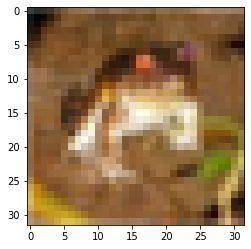

In [ ]:
image = detransformer(dataset[0][0])
plt.imshow(image)

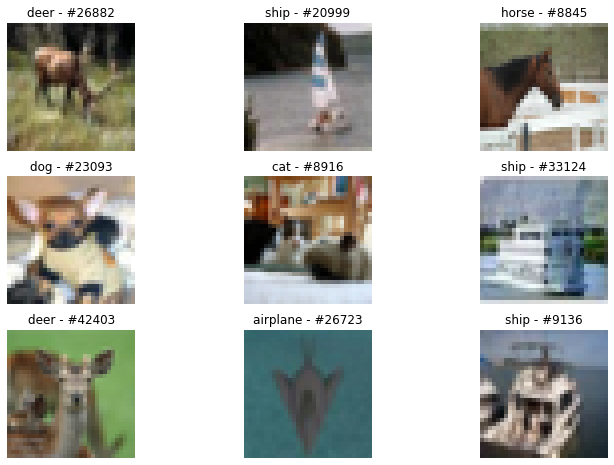

In [ ]:
print_images()

In [ ]:
# Define dataloaders for the training / validation and test datasets
validation_length = 5000
batch_size = 256

In [ ]:
# Split training dataset between actual train and validation datasets
train_dataset, validation_dataset = random_split(dataset, [(dataset_length - validation_length), validation_length])

In [ ]:
# Create loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Print some statistics
print(f'Batch size: {batch_size} data points')
print(f'Train dataset (# of batches): {len(train_dataloader)}')
print(f'Validation dataset (# of batches): {len(validation_dataloader)}')
print(f'Test dataset (# of batches): {len(test_dataloader)}')

Batch size: 256 data points
Train dataset (# of batches): 176
Validation dataset (# of batches): 20
Test dataset (# of batches): 40


In [ ]:
# Before CNN definition, let's check the sizing of input tensor
data, label = next(iter(train_dataloader))
print(data.size())
print(label.size())

torch.Size([256, 3, 32, 32])
torch.Size([256])


In [ ]:
class CifarNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2d(3, 128, kernel_size=(5,5), stride=1, padding='same')  # [B, 128, 32, 32]
    self.bnorm1 = BatchNorm2d(128)
    self.conv2 = Conv2d(128, 128, kernel_size=(5,5), stride=1, padding='same')  # [B, 128, 32, 32]
    self.bnorm2 = BatchNorm2d(128)
    self.pool1 = MaxPool2d((2,2))  # [B, 128, 16, 16]
    self.conv3 = Conv2d(128, 64, kernel_size=(5,5), stride=1, padding='same')  # [B, 64, 16, 16]
    self.bnorm3 = BatchNorm2d(64)
    self.conv4 = Conv2d(64, 64, kernel_size=(5,5), stride=1, padding='same')  # [B, 64, 16, 16]
    self.bnorm4 = BatchNorm2d(64)
    self.pool2 = MaxPool2d((2,2))  # [B, 64, 8, 8]
    self.conv5 = Conv2d(64, 32, kernel_size=(5,5), stride=1, padding='same')  # [B, 32, 8, 8]
    self.bnorm5 = BatchNorm2d(32)
    self.conv6 = Conv2d(32, 32, kernel_size=(5,5), stride=1, padding='same')  # [B, 32, 8, 8]
    self.bnorm6 = BatchNorm2d(32)
    self.pool3 = MaxPool2d((2,2))  # [B, 32, 4, 4]
    self.conv7 = Conv2d(32, 16, kernel_size=(3,3), stride=1, padding='same')  # [B, 16, 4, 4]
    self.bnorm7 = BatchNorm2d(16)
    self.conv8 = Conv2d(16, 16, kernel_size=(3,3), stride=1, padding='same')  # [B, 16, 4, 4]
    self.bnorm8 = BatchNorm2d(16)    
    self.linear1 = Linear(16*4*4, 32)
    self.drop1 = Dropout(0.15)
    self.linear2 = Linear(32, 16)
    self.drop2 = Dropout(0.05)
    self.linear3 = Linear(16, 10)

  def forward(self, x):
    # the first conv group
    x = self.bnorm1(self.conv1(x))
    x = self.bnorm2(self.conv2(x))
    x = self.pool1(x)

    # the second conv group
    x = self.bnorm3(self.conv3(x))
    x = self.bnorm4(self.conv4(x))
    x = self.pool2(x)

    # the third conv group
    x = self.bnorm5(self.conv5(x))
    x = self.bnorm6(self.conv6(x))
    x = self.pool3(x)

    # the fourth conv group (no maxpooling at the end)
    x = self.bnorm7(self.conv7(x))
    x = self.bnorm8(self.conv8(x))

    # flatten
    x = x.reshape( -1, 16*4*4) 

    # the first linear layer with ReLU
    x = self.linear1(x)
    x = F.relu(x)

    # the first dropout
    x = self.drop1(x)

    # the second linear layer with ReLU
    x = self.linear2(x)
    x = F.relu(x)

    # the second dropout
    x = self.drop2(x)

    # the output layer logits (10 neurons)
    x = self.linear3(x)
  
    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = CifarNN()
model = model.to(device)

In [ ]:
epochs = 40
learning_rate = 0.001
train_accuracies = []  # cummulated accuracies from training dataset for each epoch
val_accuracies = []  # cummulated accuracies from validation dataset for each epoch
optimizer = Adam( model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()

In [ ]:
start = timer()

for epoch in range(epochs):
  model.train()
  train_accuracy = []
  for x, y in train_dataloader:
    x = x.to(device)
    y = y.to(device)    
    optimizer.zero_grad()
    yhat = model.forward(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    prediction = torch.argmax(yhat, dim=1)
    train_accuracy.extend((y == prediction).detach().cpu().numpy()) 
  train_accuracies.append(np.mean(train_accuracy)*100)

  # for every epoch we do a validation step to asses accuracy and overfitting
  model.eval()
  with torch.no_grad():
    val_accuracy = []  # accuracies for each batch of validation dataset
    for vx, vy in validation_dataloader:
      vx = vx.to(device)
      vy = vy.to(device)
      yhat = model.forward(vx)
      prediction = torch.argmax(yhat, dim=1)
    
      # to numpy in order to use next the vectorized np.mean
      val_accuracy.extend((vy == prediction).detach().cpu().numpy()) 
    val_accuracies.append(np.mean(val_accuracy)*100)
  
  # simple logging during training
  print(f'Epoch #{epoch+1}. Train accuracy: {np.mean(train_accuracy)*100:.2f}. \
        Validation accuracy: {np.mean(val_accuracy)*100:.2f}')

end = timer()

Epoch #1. Train accuracy: 34.20.         Validation accuracy: 47.32
Epoch #2. Train accuracy: 51.58.         Validation accuracy: 57.00
Epoch #3. Train accuracy: 58.11.         Validation accuracy: 61.56
Epoch #4. Train accuracy: 62.18.         Validation accuracy: 64.16
Epoch #5. Train accuracy: 65.03.         Validation accuracy: 67.10
Epoch #6. Train accuracy: 67.13.         Validation accuracy: 68.88
Epoch #7. Train accuracy: 68.75.         Validation accuracy: 67.42
Epoch #8. Train accuracy: 69.96.         Validation accuracy: 69.74
Epoch #9. Train accuracy: 71.50.         Validation accuracy: 69.62
Epoch #10. Train accuracy: 72.94.         Validation accuracy: 71.76
Epoch #11. Train accuracy: 74.09.         Validation accuracy: 70.48
Epoch #12. Train accuracy: 75.16.         Validation accuracy: 69.50
Epoch #13. Train accuracy: 76.00.         Validation accuracy: 73.06
Epoch #14. Train accuracy: 77.10.         Validation accuracy: 72.44
Epoch #15. Train accuracy: 78.11.         V

In [ ]:
print(f'Processing time on a GPU: {end-start:.2f}s.') 

Processing time on a GPU: 3113.36s.


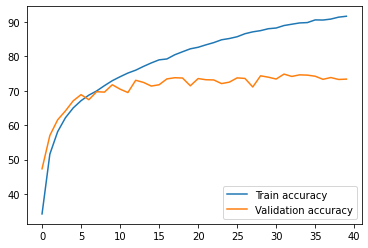

In [ ]:
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(val_accuracies, label="Validation accuracy")
leg = plt.legend(loc='lower right')
plt.show()

In [ ]:
# calculate accuracy on the test dataset that the model has never seen before
model.eval()
with torch.no_grad():
  test_accuracies = []
  for x, y in test_dataloader:
    x = x.to(device)
    y = y.to(device)    
    yhat = model.forward(x)
    prediction = torch.argmax(yhat, dim=1)
    test_accuracies.extend((prediction == y).detach().cpu().numpy())  # we store accuracy using numpy
  test_accuracy = np.mean(test_accuracies)*100              # to easily compute mean on boolean values

print(f'Accuracy on the test set: {test_accuracy:.2f}%')  

Accuracy on the test set: 72.78%


In [ ]:
# Batch size: 256

# Processing time on a CPU: unbearable.
# Around 200 iterations on train and validation * 13s = 2600s per epoch
# ~43min per epoch
# Accuracy on the test set: unknown

# Processing time on cuda: 
# Around 66s per epoch - 40 times faster 
# Accuracy on the test set: 72% (on 40 epochs)